In [1]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [2]:
query_job3 = bigquery_client.query(query)
test_df = query_job3.to_dataframe()
#test_df["time"] = pd.datetime(2022-09-24, format = %Y%m%d)
test_df["day"] = 6
test_df["month"]=11

NameError: name 'bigquery_client' is not defined

In [3]:
test_df.drop_duplicates()

NameError: name 'test_df' is not defined

In [4]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [5]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n!pip install chardet\n!pip install db-dtypes\n!pip install catboost\n")

In [6]:
#Importing Libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import csv
import numpy as np

In [8]:
from google.cloud import bigquery
import scipy as sp
import statsmodels as sm
import statistics as stat
import sklearn
import patsy as pt
import chardet as ch
import click as cl
import cytoolz as cz
import dask
import decorator as dr
#import pyjson5 as py
import jsonschema as js
import tables
import db_dtypes
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

ModuleNotFoundError: No module named 'chardet'

In [9]:
global df3

In [10]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [11]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [12]:
query_job1 = bigquery_client.query(query)
query_job1

QueryJob<project=ironhacks-data, location=US, id=d293c5e0-2681-44aa-a367-ae2aec65f2a7>

In [13]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [14]:
query_job2 = bigquery_client.query(query)
query_job2

QueryJob<project=ironhacks-data, location=US, id=5147d853-909a-4d7a-a6f2-32d6d1986ec7>

In [15]:
!pip install db-dtypes
df1 = query_job2.to_dataframe()
df1.uu_id.nunique()

525

In [16]:
!pip install db-dtypes
df2 = query_job1.to_dataframe()
df2.uu_id.nunique()

525

In [17]:
df3 = pd.merge(df1,df2, on= ["uu_id","countyfips","tract","tract_name"])

In [18]:
#Expanding timeperiod to day, month and year
df3["time"] = pd.to_datetime(df3["timeperiod"], format= '%Y%m%d', errors = "coerce")
df3 =df3.drop("timeperiod", axis = 1)
df3["month"] = df3["time"].dt.month
df3["day"] = df3["time"].dt.day
str_col = ["tract_name", 'top_category_employer1', 'top_category_employer2',
       'top_category_employer3',"time"]
df3["uu_id_enc"] = df3["uu_id"].astype('category').cat.codes
#Encoding Strings
for col in str_col :
    df3[col] = df3[col].astype('category').cat.codes
int_col = list(set(df3.columns) -set(str_col)-set(["uu_id"]))
#dropping and replacing Nan, NaT   
df3 =df3.astype(str)
df3 = df3[df3["uu_id"] != np.nan]
df3 = df3.replace('NaT', np.nan)
df3 = df3.replace(str(np.nan),str(0))
#df3 = df3.dropna(subset = ["uu_id"], inplace=True)
for col in df3.columns:
    df3[col] = df3[col].str.replace(str("<NA>"),"0")
for col in int_col:
    df3[col] =df3[col].astype(float)
df = df3.copy()
df3.uu_id.nunique()

525

In [19]:
df3 = df.copy()
df3.columns

Index(['uu_id', 'week_number', 'countyfips', 'tract', 'tract_name',
       'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage',
       'time', 'month', 'day', 'uu_id_enc'],
      dtype='object')

In [20]:
races = ['race_black', 'race_other', 'race_white']
#for j in races:
g = (sum([df3[k] for k in races]))
df3["normalized_"+ str("races") ] = g
df3["normalized_"+ str("races") ].unique()

array([ 11.,   0.,  15.,  14.,  20.,  17.,  10.,  32.,  34.,  22.,  25.,
        46.,  60.,  29.,  42.,  16.,  12.,  21.,  39.,  13.,  57.,  55.,
        43.,  18.,  92.,  24.,  19.,  82.,  90., 142.,  47.,  33.,  75.,
       135.,  31.,  26.,  73.,  28., 109.,  37.,  23.,  27.,  30.,  38.,
        41.,  52.,  45.,  71.,  61.,  40.,  44.,  84.,  36.,  35.,  53.,
        89.,  70.,  64.,  63.,  59.,  49.,  68.,  51.,  76.,  58.,  65.,
        50.,  79.,  48.,  56.,  69.,  62.,  72.,  74.,  54.,  66.,  85.,
       105., 101., 140.,  83.,  87.,  96., 103.,  97.,  77., 138.,  67.,
        81.,  86., 117., 111.,  88.,  91., 128.,  93., 108., 155., 163.,
        99.,  78.,  80., 107., 100.,  95., 112., 110.,  94.])

In [21]:
ed = ['edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs']
for j in ed:
    df3["normalized_"+ str("education") ] = sum([df3[k] for k in ed])

In [22]:
gen = [ 'gender_female', 'gender_male']
for j in gen:
    df3["normalized_"+ str("gender") ] = sum([df3[k] for k in gen])

In [23]:
df3["sum"] = (df3["normalized_"+ str("education") ]+df3["normalized_"+ str("races") ]+df3["normalized_"+ str("gender") ])

In [24]:
def opt_features(x):
    df3["opt_var"]= (x[3]*df3["normalized_"+ str("education") ]**x[0]+x[4]*df3["normalized_"+ str("races") ]**x[1]+x[5]*df3["normalized_"+ str("gender") ]**x[2]+x[6])
    df4 =df3.corr()
    corr = -df4.loc["opt_var","total_claims"]
    return corr
import scipy   
op = scipy.optimize.minimize(opt_features, [1]*7,method="SLSQP") 
op

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_13534/3549868753.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 =df3.corr()


     fun: -0.939114895616644
     jac: array([ 4.24385071e-05, -2.17661262e-04,  1.90749764e-04,  5.78165054e-06,
       -2.16342509e-04,  2.59578228e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 244
     nit: 30
    njev: 30
  status: 0
 success: True
       x: array([1.04031784, 1.33646238, 1.36444524, 2.26265948, 0.35521683,
       0.23040335, 1.        ])

In [25]:
def opt_features2(x):
    #corr = -df4.loc["opt_var1","total_claims"]
    df3["opt_var2"]=x[0]*df3["opt_var"]+x[1]*df3["week_number"]
    df3["error"]= df3["total_claims"]-df3["opt_var2"]
    return abs(df3["error"]).sum()
cons = ({'type': 'ineq',
       'fun': lambda x:  opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  -opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  x[1]-1
       })
op2 = scipy.optimize.minimize(opt_features2, [1]*7,method="SLSQP", constraints = cons) 
op2

     fun: 817140.3252665871
     jac: array([815493.328125, 337886.      ,      0.      ,      0.      ,
            0.      ,      0.      ,      0.      ])
 message: 'Positive directional derivative for linesearch'
    nfev: 8
     nit: 5
    njev: 1
  status: 8
 success: False
       x: array([1., 1., 1., 1., 1., 1., 1.])

In [26]:
df3["opt_var2"]=df3["opt_var"]+df3["opt_var2"]

In [27]:
df4 = df3.corr()
df4

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_13534/3822703957.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 = df3.corr()


,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
week_number,1.000000,-0.001015,-0.007765,-0.054817,0.019532,0.003564,-0.073129,0.003422,-0.006047,-0.033730,...,0.994291,0.025037,-0.006156,-0.048913,-0.054185,-0.039989,-0.052532,-0.048836,0.029686,-0.144117
countyfips,-0.001015,1.000000,0.014993,-0.011242,-0.002837,-0.003048,-0.005792,-0.019259,0.009003,-0.021396,...,-0.000952,0.000457,-0.015962,-0.024707,-0.015422,-0.025740,-0.024637,-0.024669,-0.024768,0.027394
tract,-0.007765,0.014993,1.000000,-0.041477,0.038854,-0.001890,-0.043448,-0.022050,0.005409,-0.020104,...,-0.007176,-0.007065,0.063204,-0.010364,-0.045897,-0.025235,-0.030135,-0.034989,-0.035625,0.033961
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939115,0.935516,-0.888512
edu_8th_or_less,0.019532,-0.002837,0.038854,0.069029,1.000000,-0.001538,0.013054,-0.006682,-0.002748,0.039022,...,0.020405,-0.008325,-0.011235,0.056605,0.006240,0.049529,0.042334,0.034951,0.036512,-0.029577
edu_grades_9_11,0.003564,-0.003048,-0.001890,0.267877,-0.001538,1.000000,0.063023,0.017355,-0.001633,0.205276,...,0.003867,-0.003019,-0.019018,0.198873,0.267673,0.206088,0.248195,0.266347,0.266828,-0.259388
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787299,0.782148,-0.763195
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541453,0.542129,-0.537103
edu_unknown,-0.006047,0.009003,0.005409,0.107267,-0.002748,-0.001633,0.011754,0.006395,1.000000,0.052286,...,-0.005783,-0.002308,0.004989,0.068465,0.012197,0.052776,0.049885,0.040790,0.040346,-0.022657
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.774904,0.772838,-0.759378


In [28]:
df4[abs(df4.total_claims)>0.5]
#df4.loc["ult","total_claims"]

,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939115,0.935516,-0.888512
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787299,0.782148,-0.763195
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541453,0.542129,-0.537103
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.774904,0.772838,-0.759378
gender_male,-0.038832,-0.025299,-0.025640,0.738217,0.050745,0.169898,0.582283,0.376703,0.043780,0.650736,...,-0.036812,-0.022545,-0.002551,0.606272,0.688769,0.912246,0.829481,0.783698,0.781238,-0.765772
race_black,-0.057827,0.010962,-0.015516,0.594516,0.012987,0.123855,0.470553,0.291321,0.051318,0.484824,...,-0.059313,0.018327,-0.003819,0.670411,0.546791,0.489177,0.626942,0.625425,0.621353,-0.604729
normalized_races,-0.048913,-0.024707,-0.010364,0.790695,0.056605,0.198873,0.594066,0.405391,0.068465,0.608157,...,-0.046182,-0.027418,-0.004696,1.000000,0.719309,0.668324,0.876010,0.843832,0.840626,-0.824175
normalized_education,-0.054185,-0.015422,-0.045897,0.897792,0.006240,0.267673,0.817667,0.578977,0.012197,0.676363,...,-0.051906,-0.022683,0.003102,0.719309,1.000000,0.751417,0.911358,0.956107,0.952571,-0.933617
normalized_gender,-0.039989,-0.025740,-0.025235,0.805103,0.049529,0.206088,0.627753,0.413722,0.052776,0.904675,...,-0.038459,-0.017745,-0.001875,0.668324,0.751417,1.000000,0.909304,0.857851,0.855356,-0.839415
sum,-0.052532,-0.024637,-0.030135,0.922510,0.042334,0.248195,0.752760,0.514986,0.049885,0.822653,...,-0.050152,-0.024817,-0.001318,0.876010,0.911358,0.909304,1.000000,0.983235,0.979849,-0.960895


In [29]:
features =df4[abs(df4.total_claims)>0.6].index
features

Index(['total_claims', 'edu_hs_grad_equiv', 'gender_female', 'gender_male',
       'normalized_races', 'normalized_education', 'normalized_gender', 'sum',
       'opt_var', 'opt_var2', 'error'],
      dtype='object')

total_claims (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


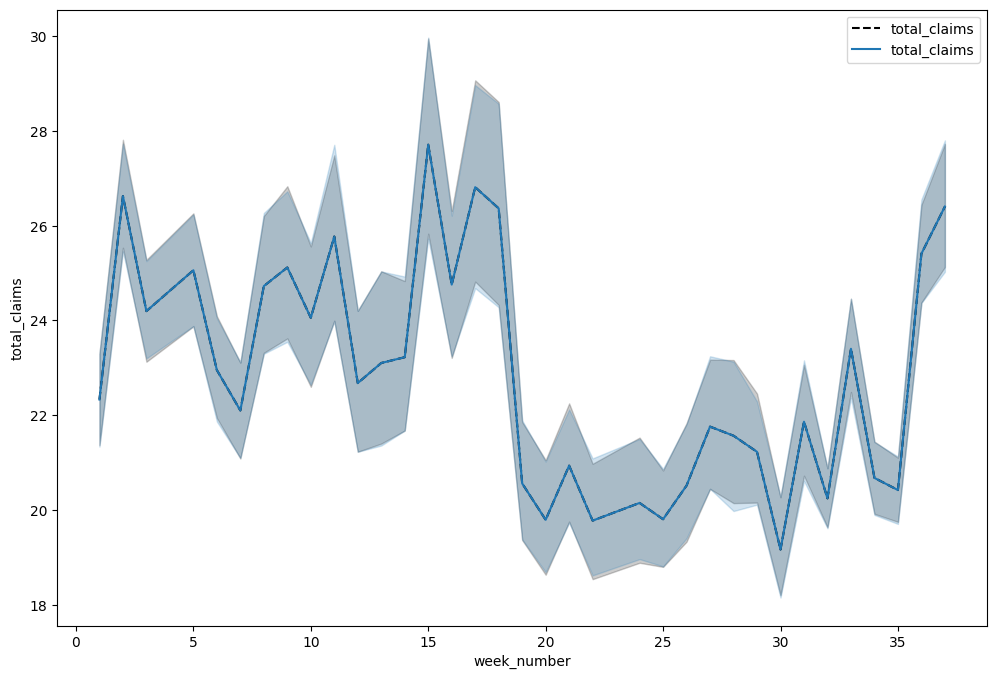

edu_hs_grad_equiv (1.0, 0.4980392156862745, 0.054901960784313725)


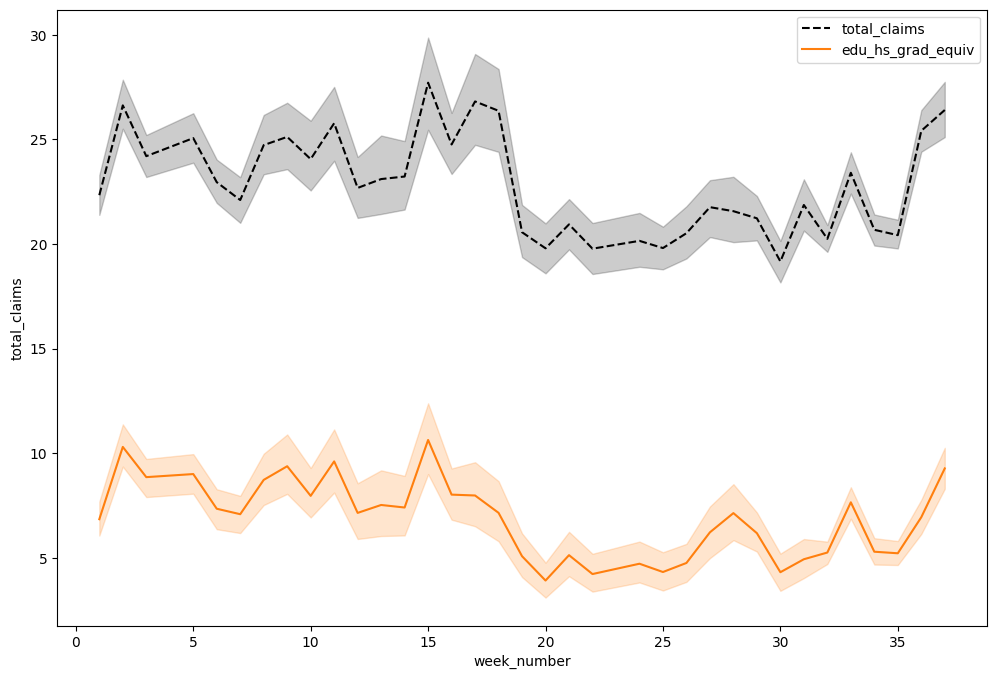

gender_female (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)


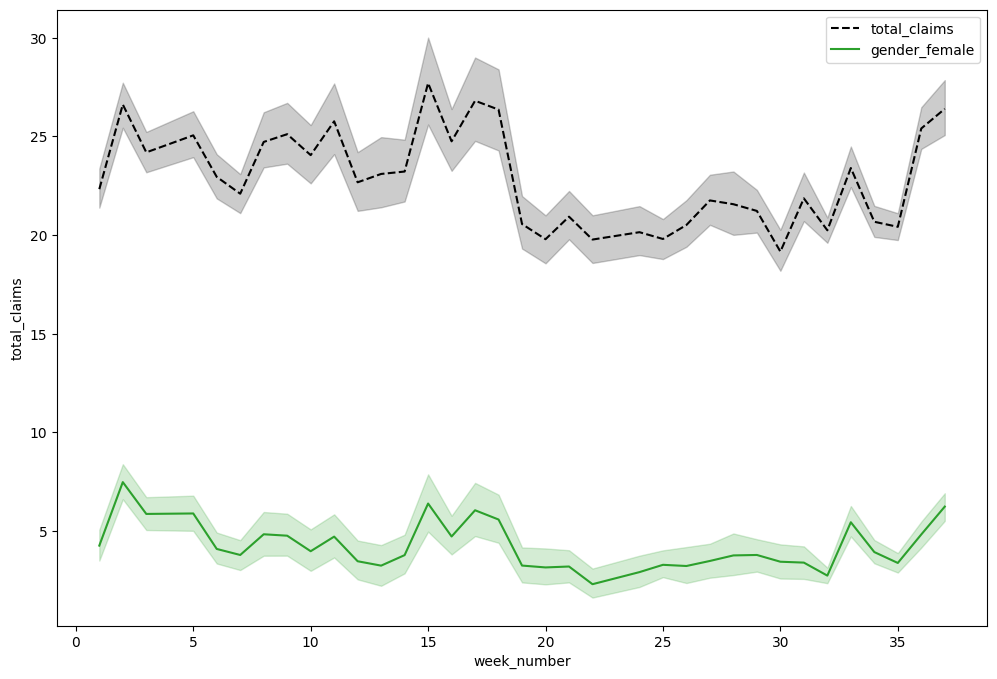

gender_male (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)


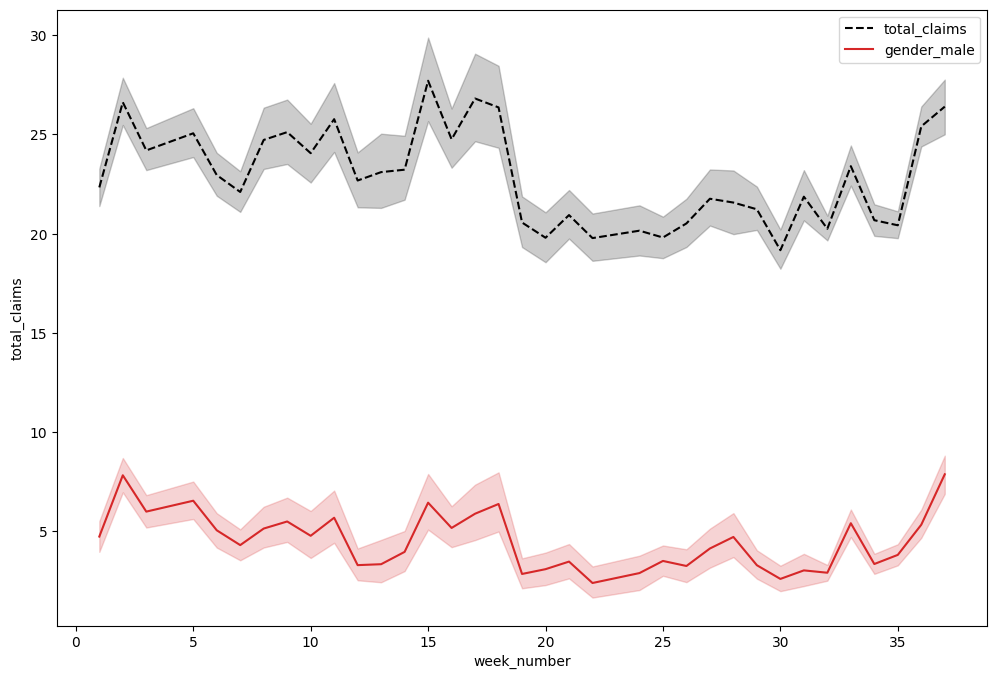

normalized_races (0.5803921568627451, 0.403921568627451, 0.7411764705882353)


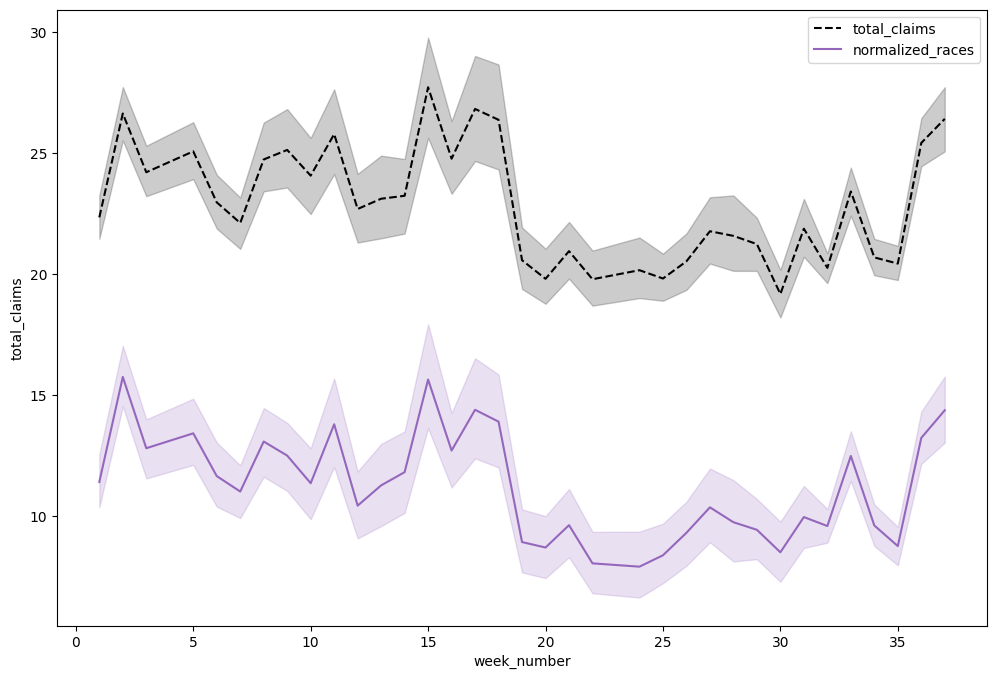

normalized_education (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)


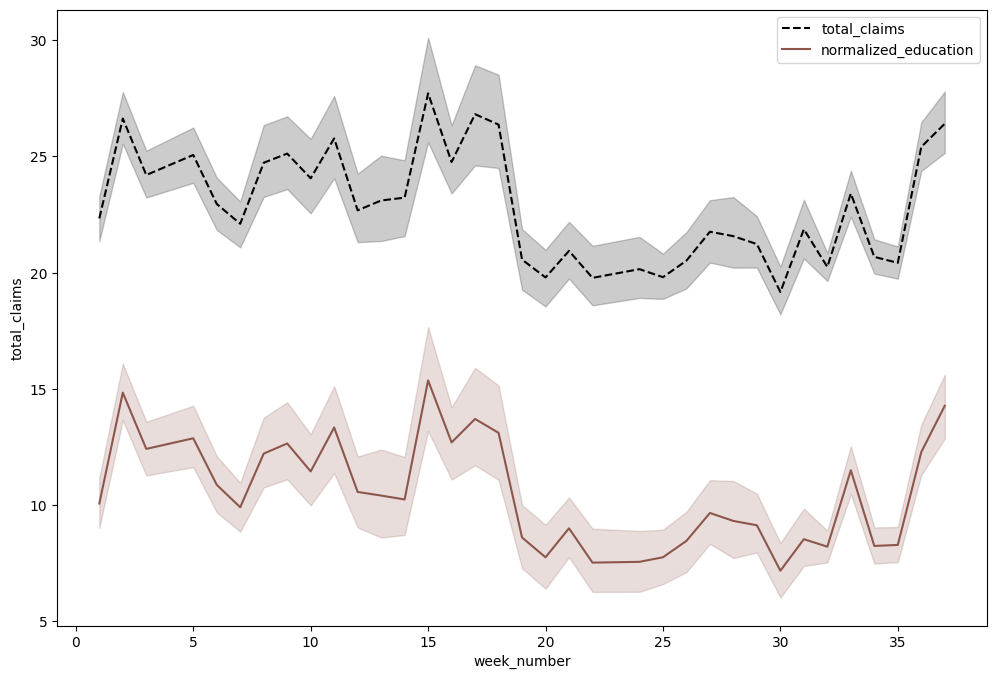

normalized_gender (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)


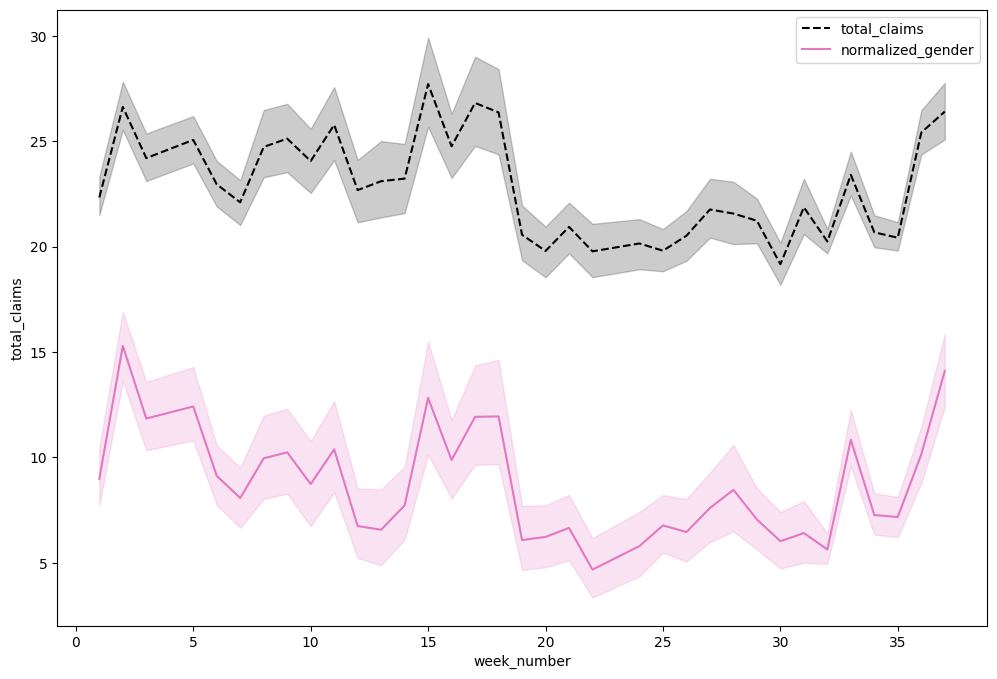

sum (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)


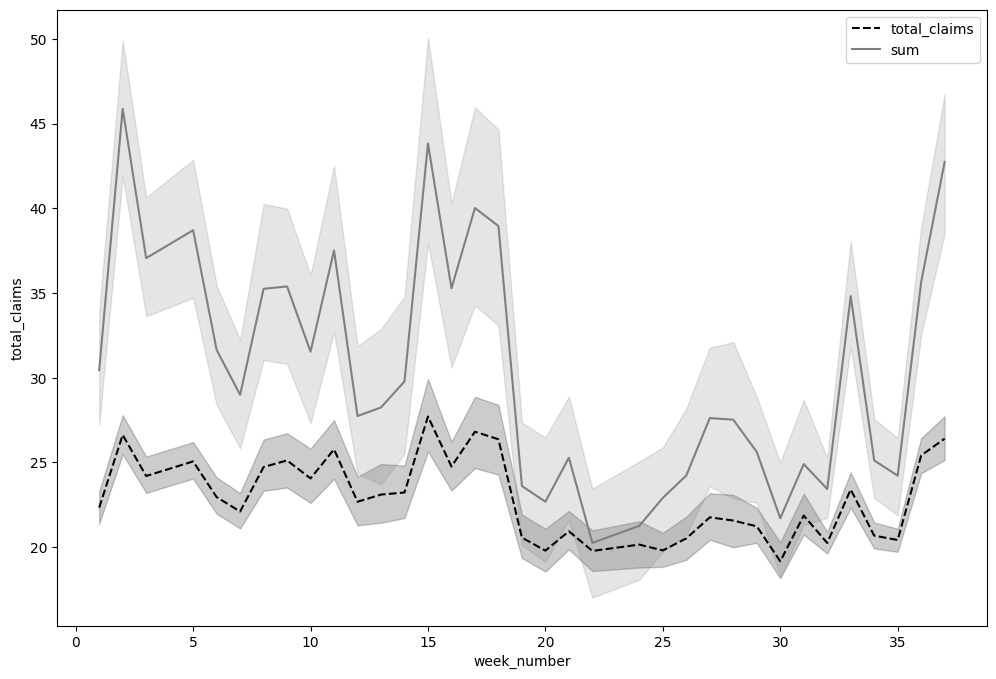

opt_var (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)


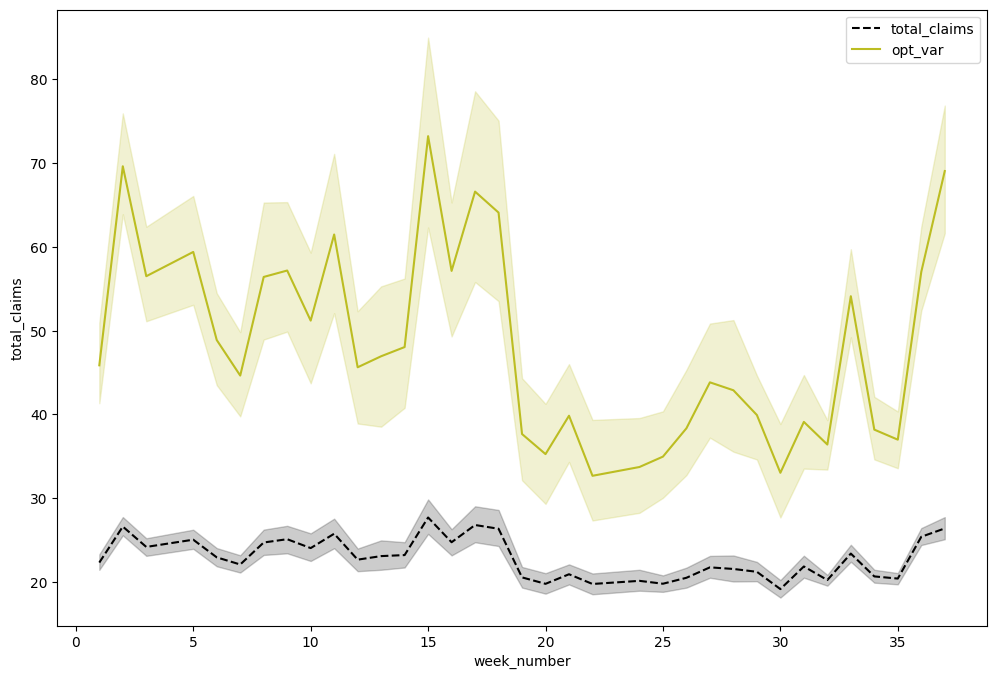

opt_var2 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)


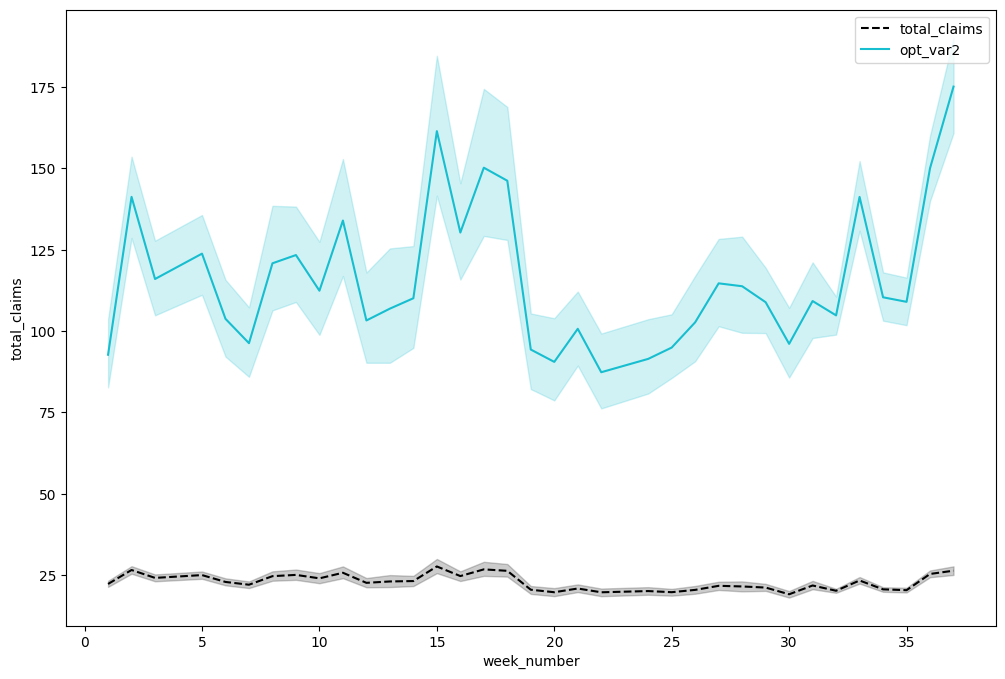

error (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


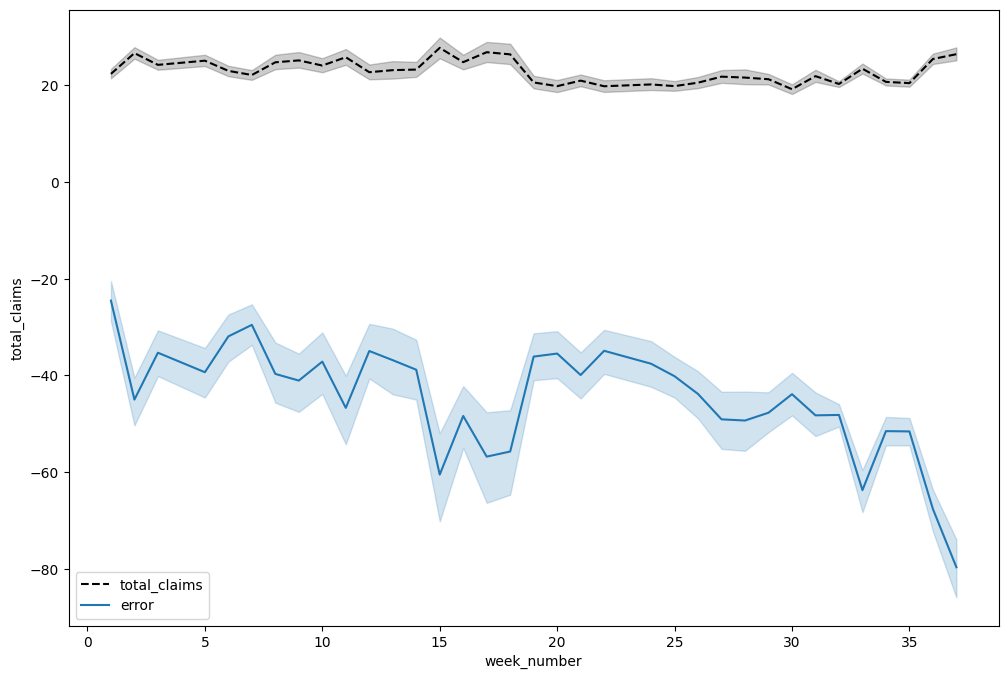

In [30]:
import itertools
colors = itertools.cycle(sns.color_palette("tab10"))
for feature in features:
    fig, ax = plt.subplots(figsize=(12,8)) 
    c = next(colors)
    print(feature, c)
    #sns.scatterplot(x= feature, y = "week_number", data =df3)
    sns.lineplot(y= "total_claims", x = "week_number", data =df3, color = "black", label = "total_claims", linestyle= "--")
    sns.lineplot(y= feature, x = "week_number", data =df3, color = c, label = feature)
    plt.show()

In [31]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as rg
sc = StandardScaler()

In [32]:
def final_pred(t):
    Y = np.array(t["total_claims"])
    X = np.array(t[[k for k in features]])
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size =0.01, random_state =5)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    rf = rg(n_estimators=1000, random_state=2)
    rf.fit(X_train, Y_train)
    return rf

In [33]:
temp = df3[[k for k in features]]
temp

,total_claims,edu_hs_grad_equiv,gender_female,gender_male,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,22.0,14.0,0.0,0.0,11.0,14.0,0.0,25.0,44.988963,105.977927,-38.988963
1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...
16828,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,16.0,10.0,0.0,0.0,0.0,10.0,0.0,10.0,25.827732,82.655463,-40.827732
16831,23.0,19.0,0.0,0.0,0.0,19.0,0.0,19.0,49.409365,107.818730,-35.409365


In [34]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [35]:
query_job3 = bigquery_client.query(query)
test_df = query_job3.to_dataframe()
#test_df["time"] = pd.datetime(2022-09-24, format = %Y%m%d)
test_df["day"] = 6
test_df["month"]=11

In [36]:
test_df.drop_duplicates()

,uu_id,week_number,day,month
0,5bf51fc2e162d6faf9e3cf79e4198378,44,6,11
1,420b44cc7e3f55d738df565421e59941,44,6,11
2,e39c66ecceec76ee8f9f811fa4a2d246,44,6,11
3,a90462cd11ae4e43144239bf7c4828a4,44,6,11
4,8b20a6749088c7ff1237983076ebfeaa,44,6,11
...,...,...,...,...
520,46c4f6c75e663b1ca82ea7994e6d83d3,44,6,11
521,1deebda501712e7595b531b8337bc31a,44,6,11
522,5a9758f65f001b6432ff31ff64a459d7,44,6,11
523,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,6,11


In [37]:
"""extras = set(test_df.uu_id.unique())-set(submission_prediction_output.uu_id.unique())
extra = [df.loc[df.uu_id==k]["uu_id_enc"].values[0] for k in extras]
extra"""

'extras = set(test_df.uu_id.unique())-set(submission_prediction_output.uu_id.unique())\nextra = [df.loc[df.uu_id==k]["uu_id_enc"].values[0] for k in extras]\nextra'

In [38]:
test_df = pd.merge(test_df, df3[["uu_id","uu_id_enc"]], on="uu_id").drop(["uu_id"], axis=1).drop_duplicates()
feature_test_pred = test_df.copy()
test_df

,week_number,day,month,uu_id_enc
0,44,6,11,198.0
10,44,6,11,126.0
18,44,6,11,476.0
32,44,6,11,353.0
58,44,6,11,288.0
...,...,...,...,...
16684,44,6,11,144.0
16722,44,6,11,52.0
16757,44,6,11,192.0
16781,44,6,11,486.0


In [39]:
"""test_df1=test_df.copy()
for col in ['total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']:
    print(col)
    test_df[col]=0
    val = ("rf")+"_"+str(col) 
    for k in extra:
        #test_df.loc[test_df.uu_id_enc==k,col] =0
        temp=df[df.uu_id_enc == k]
        temp["average_wage"]=-9999
        temp =temp.replace("",0)
        feature_test_pred = np.array(test_df1[test_df1.uu_id_enc==k])
        #print(k, temp)
        val = time_pred(temp, col)
        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))
        idk = float(val.predict(np.array(feature_test_pred))[0])
        print(idk)
        test_df.loc[test_df.uu_id_enc==k,col].value  = idk
test_df"""

'test_df1=test_df.copy()\nfor col in [\'total_claims\', \'edu_8th_or_less\', \'edu_grades_9_11\',\n       \'edu_hs_grad_equiv\', \'edu_post_hs\', \'edu_unknown\',\n       \'top_category_employer1\', \'top_category_employer2\',\n       \'top_category_employer3\', \'gender_female\', \'gender_male\', \'gender_na\',\n       \'race_amerindian\', \'race_asian\', \'race_black\', \'race_noanswer\',\n       \'race_hawaiiannative\', \'race_other\', \'race_white\', \'average_wage\']:\n    print(col)\n    test_df[col]=0\n    val = ("rf")+"_"+str(col) \n    for k in extra:\n        #test_df.loc[test_df.uu_id_enc==k,col] =0\n        temp=df[df.uu_id_enc == k]\n        temp["average_wage"]=-9999\n        temp =temp.replace("",0)\n        feature_test_pred = np.array(test_df1[test_df1.uu_id_enc==k])\n        #print(k, temp)\n        val = time_pred(temp, col)\n        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))\n        idk = float(val.predict(np.array(featur

In [40]:
df3

,uu_id,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,f013068de98db1470bd986137a0c6d23,16.0,18003.0,900.0,451,22.0,0.0,0.0,14.0,0.0,...,4.0,16.0,494.0,11.0,14.0,0.0,25.0,44.988963,105.977927,-38.988963
1,f013068de98db1470bd986137a0c6d23,7.0,18003.0,900.0,451,10.0,0.0,0.0,0.0,0.0,...,2.0,12.0,494.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,f013068de98db1470bd986137a0c6d23,35.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,8.0,27.0,494.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,f013068de98db1470bd986137a0c6d23,11.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,3.0,12.0,494.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,f013068de98db1470bd986137a0c6d23,6.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,2.0,5.0,494.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,33f8f477e670b3cac704f4c0faa6e318,10.0,18113.0,971900.0,516,11.0,0.0,0.0,0.0,0.0,...,3.0,5.0,100.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,33f8f477e670b3cac704f4c0faa6e318,6.0,18113.0,971900.0,516,10.0,0.0,0.0,0.0,0.0,...,2.0,5.0,100.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,33f8f477e670b3cac704f4c0faa6e318,31.0,18113.0,971900.0,516,16.0,0.0,0.0,10.0,0.0,...,7.0,30.0,100.0,0.0,10.0,0.0,10.0,25.827732,82.655463,-40.827732
16831,33f8f477e670b3cac704f4c0faa6e318,9.0,18113.0,971900.0,516,23.0,0.0,0.0,19.0,0.0,...,2.0,26.0,100.0,0.0,19.0,0.0,19.0,49.409365,107.818730,-35.409365


In [41]:
from statsmodels.tsa.stattools import adfuller
adfuller(df3["total_claims"])

(-15.17531611425795,
 6.306874201039816e-28,
 25,
 16807,
 {'1%': -3.430739141371555,
  '5%': -2.8617119850098525,
  '10%': -2.566861543233935},
 134499.30246634077)

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

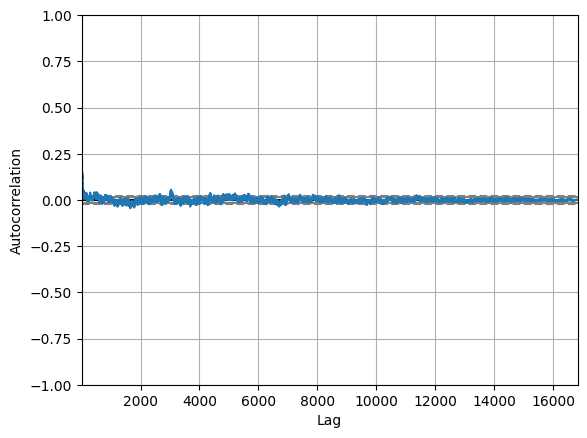

In [42]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df3["total_claims"])

In [43]:
df3 =df3.dropna()
for col in features:
    print(col)
    test_df[col]=0
    val = ("rf")+"_"+str(col) 
    for k in df3.uu_id_enc.unique():
        temp=df3[df3.uu_id_enc == k]
        val = time_pred(temp, col)
        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))
        test_df.loc[test_df.uu_id_enc==k,col] = val.predict(np.array(feature_test_pred))[0]
test_df

total_claims


NameError: name 'time_pred' is not defined

In [44]:
#df3 =df3.dropna()
li=[]
import statsmodels.api as sm
import statistics    
for k in df3.uu_id_enc.unique():
    temp=df3[df3.uu_id_enc == k]
    temp = temp.sort_values("week_number")
    df3_ = pd.concat([temp,test_df])
    df3_=df3_[["week_number","uu_id_enc","total_claims"]].drop_duplicates()
    #df3_["predicted_total_claims"]=0
    mod = sm.tsa.statespace.SARIMAX(np.array(temp["total_claims"]),
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, 2),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    try: 
        results = mod.fit()
    except IndexError:
        g = df3[df3.uu_id_enc==k]
        val= g[g.week_number==39]['total_claims'].mean()
    pred = results.get_prediction(start=40, end =40, dynamic=False)
    val = (pred.predicted_mean)
    test_df.loc[test_df.uu_id_enc==k,"total_claims"] = val
    li.append(pred.predicted_mean)
    pred_ci = pred.conf_int()
    #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51304D+00    |proj g|=  7.30584D-02

At iterate    5    f=  2.36879D+00    |proj g|=  3.32271D-01

At iterate   10    f=  2.23125D+00    |proj g|=  8.98104D-02

At iterate   15    f=  2.21721D+00    |proj g|=  5.25696D-02

At iterate   20    f=  2.21388D+00    |proj g|=  5.54572D-03

At iterate   25    f=  2.21384D+00    |proj g|=  5.29234D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.40117D+00    |proj g|=  1.93480D-01

At iterate   15    f=  3.34747D+00    |proj g|=  8.42905D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     28      1     0     0   2.994D-06   3.347D+00
  F =   3.3474265098830625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32332D+00    |proj g|=  9.24847D-02

At iterate    5    f=  4.30787D+00    |proj g|=  1.33549D-02

At iter


At iterate   15    f=  2.75516D+00    |proj g|=  4.29095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   5.058D-06   2.755D+00
  F =   2.7551425234405604     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16797D+00    |proj g|=  6.64345D-02

At iterate    5    f=  3.03233D+00    |proj g|=  1.15997D-01

At iterate   10    f=  2.88260D+00    |proj g|=  6.29058D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58870D+00    |proj g|=  8.65774D-02

At iterate    5    f=  3.57191D+00    |proj g|=  4.91654D-02

At iterate   10    f=  3.48105D+00    |proj g|=  1.18312D-01

At iterate   15    f=  3.44817D+00    |proj g|=  7.07627D-03

At iterate   20    f=  3.44810D+00    |proj g|=  5.51027D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   9.949D-06   3.448D+00
  F =   3.4480953569994686     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19548D+00    |proj g|=  2.88887D-02

At iterate    5    f=  3.18798D+00    |proj g|=  1.33516D-02

At iterate   10    f=  3.17927D+00    |proj g|=  4.65527D-03

At iterate   15    f=  3.17922D+00    |proj g|=  1.96317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   8.341D-06   3.179D+00
  F =   3.1792209601241108     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44778D+00    |proj g|=  7.48523D-02

At iterate    5    f=  3.41317D+00    |proj g|=  9.46198D-02

At iterate   10    f=  3.26122D+00    |proj g|=  9.29304D-02

At iterate   15    f=  3.24931D+00    |proj g|=  3.08920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   6.237D-06   3.249D+00
  F =   3.2492910544540363     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.32217D+00    |proj g|=  5.79645D-02

At iterate   20    f=  3.29514D+00    |proj g|=  8.60600D-03

At iterate   25    f=  3.29505D+00    |proj g|=  1.18221D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     36      1     0     0   1.182D-06   3.295D+00
  F =   3.2950476747826629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81662D+00    |proj g|=  1.01022D-01

At iter


At iterate   15    f=  2.04168D+00    |proj g|=  6.01365D-03

At iterate   20    f=  2.04135D+00    |proj g|=  8.37454D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   7.872D-06   2.041D+00
  F =   2.0413474003391765     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66935D+00    |proj g|=  1.28312D-01

At iterate    5    f=  2.62110D+00    |proj g|=  1.82384D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.39129D+00    |proj g|=  7.45724D-02

At iterate   20    f=  3.36725D+00    |proj g|=  6.68478D-02

At iterate   25    f=  3.36569D+00    |proj g|=  6.32310D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     43      1     0     0   1.501D-05   3.366D+00
  F =   3.3656934925099700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59467D+00    |proj g|=  1.25886D-01

At iter


At iterate   15    f=  3.59040D+00    |proj g|=  4.39287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   1.039D-05   3.590D+00
  F =   3.5903813242844698     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42367D+00    |proj g|=  1.34914D-01

At iterate    5    f=  3.38912D+00    |proj g|=  4.22465D-02

At iterate   10    f=  3.37344D+00    |proj g|=  6.75402D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.13457D+00    |proj g|=  2.93804D-02

At iterate   10    f=  3.02395D+00    |proj g|=  8.77555D-02

At iterate   15    f=  2.98377D+00    |proj g|=  1.39649D-02

At iterate   20    f=  2.98360D+00    |proj g|=  1.53695D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     27      1     0     0   1.537D-06   2.984D+00
  F =   2.9835975517345612     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate   10    f=  2.26633D+00    |proj g|=  7.68770D-03

At iterate   15    f=  2.26623D+00    |proj g|=  7.33610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   2.289D-06   2.266D+00
  F =   2.2662288284245382     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09428D+00    |proj g|=  9.52733D-02

At iterate    5    f=  3.04565D+00    |proj g|=  1.49146D-02

At iter


At iterate    5    f=  3.31291D+00    |proj g|=  7.06740D-02

At iterate   10    f=  3.27501D+00    |proj g|=  1.52466D-03

At iterate   15    f=  3.27477D+00    |proj g|=  3.94314D-02

At iterate   20    f=  3.27221D+00    |proj g|=  3.28320D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   6.034D-06   3.272D+00
  F =   3.2722105498175820     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.70998D+00    |proj g|=  5.21659D-02

At iterate   10    f=  3.59258D+00    |proj g|=  2.23361D-01

At iterate   15    f=  3.43047D+00    |proj g|=  3.43466D-02

At iterate   20    f=  3.42977D+00    |proj g|=  5.08784D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   5.088D-06   3.430D+00
  F =   3.4297745371901129     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate    5    f=  3.58942D+00    |proj g|=  4.32960D-02

At iterate   10    f=  3.54595D+00    |proj g|=  6.70015D-02

At iterate   15    f=  3.43545D+00    |proj g|=  9.49039D-02

At iterate   20    f=  3.42616D+00    |proj g|=  5.25334D-03

At iterate   25    f=  3.42610D+00    |proj g|=  4.53480D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   4.061D-06   3.426D+00
  F =   3.4261025796923441     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.56521D+00    |proj g|=  2.79226D-01

At iterate   10    f=  1.55181D+00    |proj g|=  5.50535D-02

At iterate   15    f=  1.53975D+00    |proj g|=  8.93721D-02

At iterate   20    f=  1.53472D+00    |proj g|=  3.54795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   3.223D-06   1.535D+00
  F =   1.5347150909247456     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate   15    f=  2.68520D+00    |proj g|=  1.50182D-02

At iterate   20    f=  2.67804D+00    |proj g|=  1.72344D-02

At iterate   25    f=  2.67767D+00    |proj g|=  3.47233D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     35      1     0     0   6.062D-06   2.678D+00
  F =   2.6776707127908912     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11126D+00    |proj g|=  6.86024D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.76576D+00    |proj g|=  2.21405D-02

At iterate   20    f=  3.76337D+00    |proj g|=  2.82801D-03

At iterate   25    f=  3.76334D+00    |proj g|=  3.22347D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   3.223D-06   3.763D+00
  F =   3.7633389572393763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22081D+00    |proj g|=  1.42501D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83582D+00    |proj g|=  1.30706D-01

At iterate    5    f=  3.80074D+00    |proj g|=  2.77901D-02

At iterate   10    f=  3.78803D+00    |proj g|=  6.71479D-02

At iterate   15    f=  3.70836D+00    |proj g|=  5.07685D-02

At iterate   20    f=  3.68230D+00    |proj g|=  3.28136D-02

At iterate   25    f=  3.68047D+00    |proj g|=  1.89814D-03

At iterate   30    f=  3.68043D+00    |proj g|=  1.14557D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f=  1.34569D+00    |proj g|=  1.77350D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     32      1     0     0   8.142D-06   1.346D+00
  F =   1.3456876556331339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35990D-01    |proj g|=  2.76687D-01

At iterate    5    f=  4.56234D-01    |proj g|=  3.15617D-01

At iterate   10    f=  1.85636D-01    |proj g|=  1.48375D+00

At iter


At iterate   25    f=  2.73181D+00    |proj g|=  5.28702D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   5.287D-06   2.732D+00
  F =   2.7318057122442010     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11007D+00    |proj g|=  8.64259D-02

At iterate    5    f=  3.05326D+00    |proj g|=  1.05647D-01

At iterate   10    f=  2.89378D+00    |proj g|=  1.05371D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.55631D+00    |proj g|=  3.07303D-02

At iterate   20    f=  3.55551D+00    |proj g|=  4.05691D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.658D-06   3.556D+00
  F =   3.5555078752055436     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total nu

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83138D+00    |proj g|=  1.32999D-01

At iterate    5    f=  2.78821D+00    |proj g|=  3.21440D-02

At iterate   10    f=  2.77643D+00    |proj g|=  5.71595D-02

At iterate   15    f=  2.76650D+00    |proj g|=  2.87829D-03

At iterate   20    f=  2.76647D+00    |proj g|=  5.48130D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.023D-05   2.766D+00
  F =   2.7664717753692694     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99713D+00    |proj g|=  1.56208D-01

At iterate    5    f=  2.90288D+00    |proj g|=  8.29620D-02

At iterate   10    f=  2.77304D+00    |proj g|=  6.02092D-02

At iterate   15    f=  2.76597D+00    |proj g|=  2.00241D-03

At iterate   20    f=  2.76595D+00    |proj g|=  1.36632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.136D-06   2.766D+00
  F =   2.7659532309003376     

CONVERG


At iterate   10    f=  2.70853D+00    |proj g|=  3.45773D-02

At iterate   15    f=  2.70495D+00    |proj g|=  9.43208D-03

At iterate   20    f=  2.70478D+00    |proj g|=  1.72629D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   1.781D-06   2.705D+00
  F =   2.7047821534648366     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88077D+00    |proj g|=  7.94994D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16777D+00    |proj g|=  2.33053D-01

At iterate    5    f=  3.11716D+00    |proj g|=  4.94556D-02

At iterate   10    f=  2.99051D+00    |proj g|=  6.11640D-02

At iterate   15    f=  2.98533D+00    |proj g|=  1.03093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   3.011D-05   2.985D+00
  F =   2.9853208596498368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69913D+00    |proj g|=  5.93902D-02

At iterate    5    f=  2.64196D+00    |proj g|=  1.26458D-01

At iterate   10    f=  2.55182D+00    |proj g|=  8.19191D-03

At iterate   15    f=  2.55070D+00    |proj g|=  1.53010D-03

At iterate   20    f=  2.55068D+00    |proj g|=  1.85732D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   2.098D-05   2.551D+00
  F =   2.5506840369818260     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     34      1     0     0   2.008D-05   3.029D+00
  F =   3.0293076704899375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91602D+00    |proj g|=  2.62429D-01

At iterate    5    f=  3.88239D+00    |proj g|=  1.48467D-02

At iterate   10    f=  3.84433D+00    |proj g|=  1.11786D-01

At iterate   15    f=  3.69825D+00    |proj g|=  1.43661D-02

At iter


At iterate    5    f=  3.73724D+00    |proj g|=  2.64740D-02

At iterate   10    f=  3.71727D+00    |proj g|=  5.49708D-02

At iterate   15    f=  3.65340D+00    |proj g|=  6.29900D-03

At iterate   20    f=  3.65333D+00    |proj g|=  3.07771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   3.594D-06   3.653D+00
  F =   3.6533310651840658     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.03373D+00    |proj g|=  2.52330D-02

At iterate   15    f=  2.03126D+00    |proj g|=  9.11840D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   2.138D-06   2.031D+00
  F =   2.0312624116182452     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94738D+00    |proj g|=  1.41720D-01

At iterate    5    f=  2.89898D+00    |proj g|=  1.07565D-01

At iter


At iterate   10    f=  2.57977D+00    |proj g|=  3.45400D-02

At iterate   15    f=  2.57659D+00    |proj g|=  3.13251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   3.897D-06   2.577D+00
  F =   2.5765709043881473     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53205D+00    |proj g|=  1.45955D-01

At iterate    5    f=  1.29653D+00    |proj g|=  3.21717D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.89553D+00    |proj g|=  1.25841D-01

At iterate   15    f=  2.87474D+00    |proj g|=  2.04526D-02

At iterate   20    f=  2.87438D+00    |proj g|=  8.50875D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     30      1     0     0   8.509D-06   2.874D+00
  F =   2.8743813183970000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16573D+00    |proj g|=  5.09323D-02

At iter


At iterate   15    f=  3.28222D+00    |proj g|=  1.76546D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   3.776D-06   3.282D+00
  F =   3.2822208177725765     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47909D+00    |proj g|=  7.20604D-02

At iterate    5    f=  2.46386D+00    |proj g|=  2.92144D-02

At iterate   10    f=  2.43300D+00    |proj g|=  8.22098D-03
  ys=-2.


At iterate   10    f=  3.58407D+00    |proj g|=  1.15893D-01

At iterate   15    f=  3.52403D+00    |proj g|=  3.65620D-02

At iterate   20    f=  3.52323D+00    |proj g|=  4.95056D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   4.951D-05   3.523D+00
  F =   3.5232347693157435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43539D+00    |proj g|=  1.15215D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.60337D+00    |proj g|=  1.17961D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   7.703D-06   2.603D+00
  F =   2.6032717954074229     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30986D+00    |proj g|=  1.22352D-01

At iterate    5    f=  2.18831D+00    |proj g|=  8.95416D-02

At iterate   10    f=  2.16255D+00    |proj g|=  8.33964D-02

At iter


At iterate   10    f=  3.39386D+00    |proj g|=  3.36222D-02

At iterate   15    f=  3.38492D+00    |proj g|=  6.09467D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   1.783D-05   3.385D+00
  F =   3.3849223929811401     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96760D+00    |proj g|=  5.12310D-02

At iterate    5    f=  2.92356D+00    |proj g|=  1.34431D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53909D+00    |proj g|=  1.67179D-01

At iterate    5    f=  2.47939D+00    |proj g|=  6.78756D-02

At iterate   10    f=  2.39908D+00    |proj g|=  3.35930D-02

At iterate   15    f=  2.38720D+00    |proj g|=  7.05736D-03

At iterate   20    f=  2.38705D+00    |proj g|=  2.52482D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     33      1     0     0   2.064D-06   2.387D+00
  F =   2.3870476121517643     

CONVERG


At iterate    0    f=  2.72416D+00    |proj g|=  1.12271D-01

At iterate    5    f=  2.61478D+00    |proj g|=  1.42533D-01

At iterate   10    f=  2.49547D+00    |proj g|=  3.49952D-02

At iterate   15    f=  2.49320D+00    |proj g|=  5.58575D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     25      1     0     0   2.889D-05   2.493D+00
  F =   2.4932024557586003     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.23467D+00    |proj g|=  8.56692D-03

At iterate   30    f=  3.23465D+00    |proj g|=  1.09370D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     44      1     0     0   1.094D-06   3.235D+00
  F =   3.2346525999335203     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77938D+00    |proj g|=  1.07426D-01

At iterate    5    f=  2.76980D+00    |proj g|=  3.17767D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35459D+00    |proj g|=  2.39526D-01

At iterate    5    f=  2.22984D+00    |proj g|=  1.89710D-02

At iterate   10    f=  2.17947D+00    |proj g|=  7.81321D-02

At iterate   15    f=  2.17685D+00    |proj g|=  3.09624D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     26      1     0     0   3.623D-05   2.177D+00
  F =   2.1768495670638801     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   25    f=  3.45987D+00    |proj g|=  5.22775D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     43      1     0     0   4.904D-05   3.460D+00
  F =   3.4598503516642669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96058D+00    |proj g|=  2.30617D-01

At iterate    5    f=  2.65101D+00    |proj g|=  7.43122D-02

At iterate   10    f=  2.64801D+00    |proj g|=  1.55108D-01

At itera


At iterate   10    f=  2.98710D+00    |proj g|=  3.85282D-03

At iterate   15    f=  2.98667D+00    |proj g|=  1.95345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   8.301D-06   2.987D+00
  F =   2.9866675116719210     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35666D+00    |proj g|=  8.77211D-02

At iterate    5    f=  3.33966D+00    |proj g|=  1.51073D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.54931D+00    |proj g|=  7.63734D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     76      2     0     0   6.047D-02   1.549D+00
  F =   1.5493108951301771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91605D+00    |proj g|=  9.04422D-02

At iterate    5    f=  2.86835D+00    |proj g|=  4.41854D-02

At iterate   10    f=  2.73556D+00    |proj g|=  1.46254D-01

At iter


At iterate    5    f=  1.95242D+00    |proj g|=  1.34547D-01

At iterate   10    f=  1.94241D+00    |proj g|=  3.27647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     19      1     0     0   1.909D-06   1.942D+00
  F =   1.9423953967105509     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28503D+00    |proj g|=  9.83726D-02

At iterate    5    f=  3.22441D+00    |proj g|=  4.93001D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39606D+00    |proj g|=  6.23181D-01

At iterate    5    f=  2.13720D+00    |proj g|=  2.01053D-01

At iterate   10    f=  2.08879D+00    |proj g|=  6.51588D-02

At iterate   15    f=  2.08557D+00    |proj g|=  2.14038D-02

At iterate   20    f=  2.08541D+00    |proj g|=  3.44507D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     31      1     0     0   3.445D-06   2.085D+00
  F =   2.0854066723727605     

CONVERG


At iterate   10    f=  3.16798D+00    |proj g|=  5.46022D-02

At iterate   15    f=  3.11295D+00    |proj g|=  3.96365D-02

At iterate   20    f=  3.11090D+00    |proj g|=  2.07531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   3.610D-05   3.111D+00
  F =   3.1108889405116780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41954D+00    |proj g|=  1.97014D-01

At iter


At iterate   25    f=  3.91335D+00    |proj g|=  1.28078D-01

At iterate   30    f=  3.89936D+00    |proj g|=  2.60932D-03

At iterate   35    f=  3.89936D+00    |proj g|=  5.41241D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     54      1     0     0   4.653D-05   3.899D+00
  F =   3.8993624812710146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29015D+00    |proj g|=  1.04898D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.12673D+00    |proj g|=  3.86600D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   3.250D-06   3.127D+00
  F =   3.1267306960977264     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


At iterate   15    f=  2.67859D+00    |proj g|=  9.53112D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   4.023D-06   2.679D+00
  F =   2.6785911722237126     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30671D+00    |proj g|=  1.41396D-01

At iterate    5    f=  3.27995D+00    |proj g|=  5.51665D-02

At iterate   10    f=  3.18571D+00    |proj g|=  2.16910D-01

At iter

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.82141D+00    |proj g|=  1.75309D-02

At iterate   10    f=  3.78832D+00    |proj g|=  5.36442D-02

At iterate   15    f=  3.68416D+00    |proj g|=  1.36170D-01

At iterate   20    f=  3.65716D+00    |proj g|=  2.01519D-03

At iterate   25    f=  3.65690D+00    |proj g|=  6.62405D-03

At iterate   30    f=  3.65685D+00    |proj g|=  7.62448D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     37      1     0     0   7.624D-05   3.657D+00
  F =   3.6568472756637855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


At iterate   15    f=  3.80532D+00    |proj g|=  8.96124D-02

At iterate   20    f=  3.75487D+00    |proj g|=  5.83744D-02

At iterate   25    f=  3.75260D+00    |proj g|=  1.99072D-02

At iterate   30    f=  3.75213D+00    |proj g|=  3.67660D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     44      1     0     0   3.568D-05   3.752D+00
  F =   3.7521313920043462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.08045D+00    |proj g|=  1.52337D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     27      1     0     0   3.711D-05   3.080D+00
  F =   3.0804365995859393     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80006D+00    |proj g|=  1.25717D-01

At iterate    5    f=  3.73580D+00    |proj g|=  2.43905D-02

At iterate   10    f=  3.54833D+00    |proj g|=  1.86402D-01

At iter


At iterate   10    f=  3.79304D+00    |proj g|=  1.20695D-01

At iterate   15    f=  3.67000D+00    |proj g|=  1.18799D-02

At iterate   20    f=  3.66958D+00    |proj g|=  1.09297D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   2.502D-06   3.670D+00
  F =   3.6695775426267003     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44635D+00    |proj g|=  2.35123D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     34      1     0     0   4.230D-05   3.007D+00
  F =   3.0069181242481080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54358D+00    |proj g|=  3.89543D-02

At iterate    5    f=  3.52212D+00    |proj g|=  2.66796D-02

At iterate   10    f=  3.39632D+00    |proj g|=  1.91307D-01

At iterate   15    f=  3.33203D+00    |proj g|=  8.12182D-02

At iter


At iterate   20    f=  3.29123D+00    |proj g|=  3.03096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     32      1     0     0   8.709D-06   3.291D+00
  F =   3.2912316522863057     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66675D+00    |proj g|=  8.50659D-02

At iterate    5    f=  2.62492D+00    |proj g|=  7.00029D-02

At iterate   10    f=  2.60500D+00    |proj g|=  2.51596D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     49      1     0     0   7.098D-06   3.801D+00
  F =   3.8014140312266629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34728D+00    |proj g|=  6.96912D-02

At iterate    5    f=  3.30780D+00    |proj g|=  7.04422D-02

At iterate   10    f=  3.15201D+00    |proj g|=  4.13220D-02

At iterate   15    f=  3.12957D+00    |proj g|=  6.35886D-02

At iter


At iterate   20    f=  3.73314D+00    |proj g|=  9.67068D-03

At iterate   25    f=  3.73305D+00    |proj g|=  5.75682D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   5.757D-06   3.733D+00
  F =   3.7330472494500375     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13730D+00    |proj g|=  1.37479D-01

At iterate    5    f=  3.05067D+00    |proj g|=  5.44071D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.36416D+00    |proj g|=  6.16979D-02

At iterate   20    f=  3.35782D+00    |proj g|=  1.16975D-02

At iterate   25    f=  3.35776D+00    |proj g|=  1.98606D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   1.986D-06   3.358D+00
  F =   3.3577621974570016     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24589D+00    |proj g|=  1.11843D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37382D+00    |proj g|=  1.56000D-01

At iterate    5    f=  3.29817D+00    |proj g|=  1.26277D-01

At iterate   10    f=  3.26923D+00    |proj g|=  8.34262D-02

At iterate   15    f=  3.16980D+00    |proj g|=  7.96609D-02

At iterate   20    f=  3.15881D+00    |proj g|=  4.78261D-03

At iterate   25    f=  3.15863D+00    |proj g|=  6.10826D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     37      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73274D+00    |proj g|=  1.70559D-01

At iterate    5    f=  3.67535D+00    |proj g|=  1.86214D-02

At iterate   10    f=  3.65958D+00    |proj g|=  6.22450D-02

At iterate   15    f=  3.60561D+00    |proj g|=  2.20451D-01

At iterate   20    f=  3.55758D+00    |proj g|=  1.20007D-02

At iterate   25    f=  3.55733D+00    |proj g|=  4.19958D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     43      1     0     0   


At iterate   20    f=  3.38553D+00    |proj g|=  1.70713D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   6.064D-05   3.386D+00
  F =   3.3855260083579450     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59683D+00    |proj g|=  1.21093D-01

At iterate    5    f=  2.54319D+00    |proj g|=  1.79499D-02

At iterate   10    f=  2.44138D+00    |proj g|=  1.18684D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.52440D+00    |proj g|=  6.43702D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     35      1     0     0   5.775D-06   3.524D+00
  F =   3.5244027027832794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.01778D+00    |proj g|=  1.53333D-01

At iterate    5    f=  2.92682D+00    |proj g|=  1.00677D-01

At iterate   10    f=  2.80266D+00    |proj g|=  2.36926D-01

At iter


At iterate   20    f=  2.65886D+00    |proj g|=  1.95666D-02

At iterate   25    f=  2.65604D+00    |proj g|=  3.31600D-02

At iterate   30    f=  2.65556D+00    |proj g|=  1.46757D-02

At iterate   35    f=  2.65556D+00    |proj g|=  7.68239D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     52      1     0     0   7.682D-06   2.656D+00
  F =   2.6555592048549657     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.09873D+00    |proj g|=  1.70952D-02

At iterate   10    f=  4.08254D+00    |proj g|=  9.82122D-02

At iterate   15    f=  3.94722D+00    |proj g|=  1.36273D-01

At iterate   20    f=  3.94112D+00    |proj g|=  3.03023D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     34      1     0     0   2.529D-05   3.941D+00
  F =   3.9411236718785019     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate   15    f=  2.78180D+00    |proj g|=  3.44744D-03

At iterate   20    f=  2.78092D+00    |proj g|=  2.93864D-03

At iterate   25    f=  2.78091D+00    |proj g|=  4.50998D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   3.987D-07   2.781D+00
  F =   2.7809091872381271     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92528D+00    |proj g|=  8.38749D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28099D+00    |proj g|=  9.23594D-02

At iterate    5    f=  3.23352D+00    |proj g|=  2.98466D-02

At iterate   10    f=  3.14084D+00    |proj g|=  6.84564D-02

At iterate   15    f=  3.09486D+00    |proj g|=  4.62840D-02

At iterate   20    f=  3.09274D+00    |proj g|=  1.58277D-02

At iterate   25    f=  3.09235D+00    |proj g|=  4.09131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   


At iterate   15    f=  1.94081D+00    |proj g|=  4.16570D-02

At iterate   20    f=  1.93943D+00    |proj g|=  2.58270D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     33      1     0     0   5.480D-06   1.939D+00
  F =   1.9394314418790439     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81419D+00    |proj g|=  1.17624D-01

At iterate    5    f=  2.70842D+00    |proj g|=  9.79113D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.17166D+00    |proj g|=  1.95448D-02

At iterate   10    f=  1.16505D+00    |proj g|=  4.68367D-02

At iterate   15    f=  1.12747D+00    |proj g|=  4.64073D-02

At iterate   20    f=  1.11987D+00    |proj g|=  2.49909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   1.191D-06   1.120D+00
  F =   1.1198608392008349     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

At iterate   20    f=  3.59948D+00    |proj g|=  3.00228D-02

At iterate   25    f=  3.59730D+00    |proj g|=  4.64196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     44      1     0     0   6.947D-06   3.597D+00
  F =   3.5973021338025277     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93812D+00    |proj g|=  4.06024D-02

At iterate    5    f=  2.83012D+00    |proj g|=  1.64685D-01

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.21742D+00    |proj g|=  4.47460D-02

At iterate   15    f=  3.21570D+00    |proj g|=  3.72169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   5.851D-06   3.216D+00
  F =   3.2156791856970366     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24638D+00    |proj g|=  2.62416D-01

At iterate    5    f=  1.16611D+00    |proj g|=  5.49685D-01

At iter

At iterate    0    f=  3.22173D+00    |proj g|=  6.98690D-02

At iterate    5    f=  3.17227D+00    |proj g|=  1.02505D-01

At iterate   10    f=  3.08001D+00    |proj g|=  1.13810D-02

At iterate   15    f=  3.07988D+00    |proj g|=  1.08477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   6.856D-07   3.080D+00
  F =   3.0798827112276337     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90509D+00    |proj g|=  9.26164D-02

At iterate    5    f=  2.86157D+00    |proj g|=  8.09034D-02

At iterate   10    f=  2.78224D+00    |proj g|=  8.56319D-02

At iterate   15    f=  2.76824D+00    |proj g|=  2.31278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   4.484D-05   2.768D+00
  F =   2.7682423828968892     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27482D+00    |proj g|=  4.59812D-02

At iterate    5    f=  2.25561D+00    |proj g|=  4.22171D-02

At iterate   10    f=  2.14650D+00    |proj g|=  3.47762D-02

At iterate   15    f=  2.13158D+00    |proj g|=  1.20548D-02

At iterate   20    f=  2.13108D+00    |proj g|=  3.51283D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   3.513D-06   2.131D+00
  F =   2.1310774436841005     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.38226D+00    |proj g|=  6.85655D-02

At iterate   10    f=  3.25606D+00    |proj g|=  1.16759D-01

At iterate   15    f=  3.24459D+00    |proj g|=  8.51748D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   2.123D-05   3.245D+00
  F =   3.2445859592560033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32182D+00    |proj g|=  8.99820D-02

At iter


At iterate   10    f=  3.15754D+00    |proj g|=  2.19255D-02

At iterate   15    f=  3.15281D+00    |proj g|=  1.40762D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   1.151D-05   3.153D+00
  F =   3.1528075446407615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28938D+00    |proj g|=  6.84809D-02

At iterate    5    f=  3.25195D+00    |proj g|=  8.38399D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.30683D+00    |proj g|=  3.79782D-02

At iterate   20    f=  3.30648D+00    |proj g|=  4.90962D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   4.123D-06   3.306D+00
  F =   3.3064807776210121     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00616D+00    |proj g|=  1.69254D-01

At iterate    5    f=  1.92942D+00    |proj g|=  5.21551D-02

At iter


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   4.979D-07   3.605D+00
  F =   3.6054385306678176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58896D+00    |proj g|=  2.41095D-01

At iterate    5    f=  2.37172D+00    |proj g|=  1.85180D-02

At iterate   10    f=  2.34095D+00    |proj g|=  1.53827D-02

At iterate   15    f=  2.34057D+00    |proj g|=  5.12882D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.10643D+00    |proj g|=  1.77257D-01

At iterate   10    f=  2.97872D+00    |proj g|=  6.21585D-02

At iterate   15    f=  2.96097D+00    |proj g|=  1.19079D-02

At iterate   20    f=  2.96085D+00    |proj g|=  3.50449D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     41      1     0     0   1.349D-04   2.961D+00
  F =   2.9608478012350146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate   10    f=  3.44766D+00    |proj g|=  7.30111D-02

At iterate   15    f=  3.36965D+00    |proj g|=  1.53907D-01

At iterate   20    f=  3.31441D+00    |proj g|=  9.76135D-03

At iterate   25    f=  3.31434D+00    |proj g|=  6.23355D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   6.234D-06   3.314D+00
  F =   3.3143447925704352     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate    5    f=  3.07349D+00    |proj g|=  3.69693D-01

At iterate   10    f=  3.03869D+00    |proj g|=  4.04030D-02

At iterate   15    f=  3.03650D+00    |proj g|=  3.88667D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     24      1     0     0   8.133D-06   3.036D+00
  F =   3.0364975062366146     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49398D+00    |proj g|=  1.06548D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78604D+00    |proj g|=  1.08559D-01

At iterate    5    f=  2.71274D+00    |proj g|=  9.50785D-02

At iterate   10    f=  2.62882D+00    |proj g|=  2.24573D-02

At iterate   15    f=  2.62839D+00    |proj g|=  2.80323D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   4.243D-06   2.628D+00
  F =   2.6283853705963991     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     25      1     0     0   2.538D-05   2.480D+00
  F =   2.4804840413234377     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70098D+00    |proj g|=  1.75489D-01

At iterate    5    f=  1.62789D+00    |proj g|=  1.18536D-02

At iterate   10    f=  1.59000D+00    |proj g|=  8.99877D-02

At iterate   15    f=  1.56194D+00    |proj g|=  3.47572D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.08419D+00    |proj g|=  1.29132D-02

At iterate   20    f=  3.08356D+00    |proj g|=  5.56134D-02

At iterate   25    f=  3.08052D+00    |proj g|=  5.03531D-03

At iterate   30    f=  3.08012D+00    |proj g|=  8.44193D-03

At iterate   35    f=  3.08008D+00    |proj g|=  6.81633D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     51      1     0     0   6.816D-06   3.080D+00
  F =   3.0800826273172803     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


At iterate   10    f=  2.70049D+00    |proj g|=  1.04031D-01

At iterate   15    f=  2.69487D+00    |proj g|=  4.93788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   1.918D-06   2.695D+00
  F =   2.6948700952893287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59953D+00    |proj g|=  1.34255D-01

At iterate    5    f=  3.55355D+00    |proj g|=  9.03544D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.97537D+00    |proj g|=  1.34322D-01

At iterate   15    f=  2.97415D+00    |proj g|=  1.53479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     26      1     0     0   2.852D-05   2.974D+00
  F =   2.9741522335631640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33298D+00    |proj g|=  1.00359D-01

At iterate    5    f=  3.28534D+00    |proj g|=  9.42693D-02

At iter


At iterate   10    f=  2.94885D+00    |proj g|=  2.98722D-02

At iterate   15    f=  2.93517D+00    |proj g|=  2.50732D-02

At iterate   20    f=  2.93457D+00    |proj g|=  6.80545D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     31      1     0     0   6.805D-06   2.935D+00
  F =   2.9345670195325710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72167D+00    |proj g|=  1.53249D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.60562D+00    |proj g|=  1.27030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     26      1     0     0   4.187D-06   2.606D+00
  F =   2.6056226268106557     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25966D+00    |proj g|=  7.64733D-02

At iterate    5    f=  3.20845D+00    |proj g|=  1.06596D-01

At iterate   10    f=  3.03241D+00    |proj g|=  4.08233D-02

At iter


At iterate   20    f=  1.65414D+00    |proj g|=  3.30418D-02

At iterate   25    f=  1.65221D+00    |proj g|=  2.16922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     42      1     0     0   3.409D-06   1.652D+00
  F =   1.6522091933464527     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71042D+00    |proj g|=  8.90918D-02

At iterate    5    f=  3.68923D+00    |proj g|=  3.38320D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.66105D+00    |proj g|=  3.09811D-02

At iterate   10    f=  3.50605D+00    |proj g|=  7.19227D-02

At iterate   15    f=  3.47605D+00    |proj g|=  2.78692D-02

At iterate   20    f=  3.47295D+00    |proj g|=  8.65343D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   3.299D-06   3.473D+00
  F =   3.4729517627699176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate    5    f=  3.03456D+00    |proj g|=  1.68145D-01

At iterate   10    f=  2.89696D+00    |proj g|=  2.08429D-02

At iterate   15    f=  2.89518D+00    |proj g|=  9.42128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   5.831D-06   2.895D+00
  F =   2.8951822765444826     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55846D+00    |proj g|=  1.62262D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.16822D+00    |proj g|=  2.14723D-01

At iterate   10    f=  2.97402D+00    |proj g|=  1.00203D-01

At iterate   15    f=  2.96442D+00    |proj g|=  6.69706D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   7.514D-07   2.964D+00
  F =   2.9644231232428284     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64292D+00    |proj g|=  1.13022D-01

At iter


At iterate   15    f=  2.44348D+00    |proj g|=  1.52349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   1.045D-06   2.443D+00
  F =   2.4434829377872824     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13991D+00    |proj g|=  3.62917D-02

At iterate    5    f=  2.93501D+00    |proj g|=  1.46207D-01

At iterate   10    f=  2.89290D+00    |proj g|=  4.26105D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.41069D+00    |proj g|=  1.28701D-01

At iterate    5    f=  3.36132D+00    |proj g|=  3.65052D-02

At iterate   10    f=  3.30463D+00    |proj g|=  1.71809D-01

At iterate   15    f=  3.21996D+00    |proj g|=  4.31217D-02

At iterate   20    f=  3.21824D+00    |proj g|=  1.35238D-03

At iterate   25    f=  3.21824D+00    |proj g|=  8.08482D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   


At iterate    5    f=  3.74704D+00    |proj g|=  9.75107D-02

At iterate   10    f=  3.61990D+00    |proj g|=  1.45724D-01

At iterate   15    f=  3.51480D+00    |proj g|=  1.76240D-02

At iterate   20    f=  3.51450D+00    |proj g|=  1.68228D-03

At iterate   25    f=  3.51450D+00    |proj g|=  1.55505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   1.555D-05   3.514D+00
  F =   3.5144963543637084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.50599D+00    |proj g|=  2.26964D-01

At iterate   15    f=  3.37447D+00    |proj g|=  3.48016D-01

At iterate   20    f=  3.37323D+00    |proj g|=  1.12054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     43      1     0     0   4.383D-05   3.373D+00
  F =   3.3732311811996438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63716D+00    |proj g|=  7.59008D-02

At iter


At iterate   15    f=  3.81718D+00    |proj g|=  9.55143D-02

At iterate   20    f=  3.73489D+00    |proj g|=  7.54456D-02

At iterate   25    f=  3.73298D+00    |proj g|=  7.45056D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     43      1     0     0   3.232D-06   3.733D+00
  F =   3.7329553935920847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54359D+00    |proj g|=  5.57369D-02

At iter


At iterate    5    f=  3.41709D+00    |proj g|=  1.25334D-01

At iterate   10    f=  3.20893D+00    |proj g|=  4.07438D-02

At iterate   15    f=  3.20723D+00    |proj g|=  1.32675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     23      1     0     0   7.226D-05   3.207D+00
  F =   3.2072327650646422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12603D+00    |proj g|=  8.51949D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.16580D+00    |proj g|=  6.91083D-02

At iterate   15    f=  3.15744D+00    |proj g|=  2.78027D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   1.936D-05   3.157D+00
  F =   3.1574412549633437     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22891D+00    |proj g|=  8.28659D-02

At iterate    5    f=  3.19568D+00    |proj g|=  1.46465D-01

At iter


At iterate   20    f=  3.11659D+00    |proj g|=  4.51348D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   1.951D-06   3.117D+00
  F =   3.1165861138484874     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16709D+00    |proj g|=  9.22674D-02

At iterate    5    f=  3.14338D+00    |proj g|=  5.77131D-02

At iterate   10    f=  3.06943D+00    |proj g|=  1.05264D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17158D+00    |proj g|=  5.06277D-02

At iterate    5    f=  3.12212D+00    |proj g|=  1.35811D-01

At iterate   10    f=  2.92677D+00    |proj g|=  3.38690D-02

At iterate   15    f=  2.90644D+00    |proj g|=  4.81662D-02

At iterate   20    f=  2.90410D+00    |proj g|=  8.52283D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     29      1     0     0   7.967D-06   2.904D+00
  F =   2.9040944745973230     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL   


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     52      2     0     0   1.255D+11   1.747D+07
  F =   17473006.991265621     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84383D+00    |proj g|=  1.73862D-01

At iterate    5    f=  3.79572D+00    |proj g|=  1.27180D-02

At iterate   10    f=  3.75617D+00    |proj g|=  5.25401D-02

At iterate   15    f=  3.65486D+00    |proj g|=  1.21798D-01

At iter

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is u


At iterate   15    f=  5.82738D-01    |proj g|=  4.49307D-03

At iterate   20    f=  5.82736D-01    |proj g|=  1.19594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     33      1     0     0   1.196D-04   5.827D-01
  F =  0.58273649307597941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83010D+00    |proj g|=  3.52763D-01

At iterate    5    f=  1.41241D+00    |proj g|=  1.58761D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16545D+00    |proj g|=  1.37935D-01

At iterate    5    f=  1.97779D+00    |proj g|=  5.91317D-02

At iterate   10    f=  1.96931D+00    |proj g|=  5.25462D-03

At iterate   15    f=  1.96926D+00    |proj g|=  3.25007D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   3.250D-07   1.969D+00
  F =   1.9692616134965020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.82393D+00    |proj g|=  1.02639D-01

At iterate   10    f=  1.77060D+00    |proj g|=  7.82085D-01

At iterate   15    f=  1.74754D+00    |proj g|=  2.39597D-01

At iterate   20    f=  1.73888D+00    |proj g|=  5.24003D-02

At iterate   25    f=  1.73881D+00    |proj g|=  9.26466D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     44      1     0     0   2.433D-04   1.739D+00
  F =   1.7388080926501479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58044D+00    |proj g|=  7.91175D-02

At iterate    5    f=  2.47021D+00    |proj g|=  4.53846D-02

At iterate   10    f=  2.46775D+00    |proj g|=  8.16146D-03

At iterate   15    f=  2.46651D+00    |proj g|=  1.51229D-02

At iterate   20    f=  2.44508D+00    |proj g|=  9.03733D-02

At iterate   25    f=  2.43363D+00    |proj g|=  4.60015D-03

At iterate   30    f=  2.43339D+00    |proj g|=  5.02269D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.97815D+00    |proj g|=  1.16616D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.609D-06   1.978D+00
  F =   1.9781527018910408     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37068D+00    |proj g|=  3.25183D-01

At iterate    5    f=  3.32988D+00    |proj g|=  2.87233D-02

At iterate   10    f=  3.16273D+00    |proj g|=  2.98539D-01

At iter


At iterate   15    f=  3.07248D+00    |proj g|=  1.02175D-01

At iterate   20    f=  3.05333D+00    |proj g|=  2.63828D-03

At iterate   25    f=  3.05333D+00    |proj g|=  3.26361D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   3.264D-06   3.053D+00
  F =   3.0533261324707670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04749D+00    |proj g|=  2.14605D-01

At iter


At iterate   20    f=  3.18453D+00    |proj g|=  2.92711D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   5.975D-05   3.185D+00
  F =   3.1845173016247688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66603D-01    |proj g|=  2.67203D-01

At iterate    5    f=  6.69802D-01    |proj g|=  2.70468D-02

At iterate   10    f=  5.62502D-01    |proj g|=  1.09518D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.27940D+00    |proj g|=  4.96082D-02

At iterate   10    f=  2.27687D+00    |proj g|=  4.32167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     23      1     0     0   8.626D-07   2.277D+00
  F =   2.2768677886034818     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78816D+00    |proj g|=  6.67732D-02

At iterate    5    f=  2.67523D+00    |proj g|=  2.81956D-01

At iter


At iterate   10    f=  2.91280D+00    |proj g|=  6.30370D-02

At iterate   15    f=  2.84031D+00    |proj g|=  2.63648D-01

At iterate   20    f=  2.83153D+00    |proj g|=  1.15070D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     33      1     0     0   5.496D-06   2.832D+00
  F =   2.8315271155828654     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21125D+00    |proj g|=  6.50640D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.69856D+00    |proj g|=  8.24342D-01

At iterate   10    f=  2.66953D+00    |proj g|=  8.96315D-02

At iterate   15    f=  2.65908D+00    |proj g|=  4.29938D-02

At iterate   20    f=  2.65464D+00    |proj g|=  1.39702D+00

At iterate   25    f=  2.64108D+00    |proj g|=  1.27814D-02

At iterate   30    f=  2.64108D+00    |proj g|=  6.63720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     45      1     0     0   2.619D-05   2.641D+00
  F =   2.6410807734538260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


At iterate   20    f=  3.19011D+00    |proj g|=  3.36979D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   4.015D-06   3.190D+00
  F =   3.1901049080320996     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.70964D+00    |proj g|=  1.73421D-01

At iterate    5    f=  2.61933D+00    |proj g|=  1.37000D-01

At iterate   10    f=  2.58877D+00    |proj g|=  7.31615D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.77618D+00    |proj g|=  5.10206D-02

At iterate   20    f=  2.77605D+00    |proj g|=  1.75473D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     39      1     0     0   1.437D-03   2.776D+00
  F =   2.7760463482107931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72393D+00    |proj g|=  4.64935D-02

At iterate    5    f=  3.71447D+00    |proj g|=  1.70885D-02

At iter


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     63      2     0     0   1.187D-05   2.594D+00
  F =   2.5943267362537163     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95150D+00    |proj g|=  1.40472D-01

At iterate    5    f=  3.90824D+00    |proj g|=  1.44281D-02

At iterate   10    f=  3.78617D+00    |proj g|=  1.06625D-01

At iterate   15    f=  3.75452D+00    |proj g|=  1.65501D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.68472D+00    |proj g|=  7.46301D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     29      1     0     0   7.463D-06   3.685D+00
  F =   3.6847167717387221     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92016D+00    |proj g|=  5.66916D-01

At iterate    5    f=  2.89728D+00    |proj g|=  2.52899D-01

At iterate   10    f=  2.88645D+00    |proj g|=  8.57149D-01

At iter


At iterate   15    f=  3.41904D+00    |proj g|=  9.71861D-02

At iterate   20    f=  3.40582D+00    |proj g|=  2.24242D-02

At iterate   25    f=  3.40517D+00    |proj g|=  1.78897D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     45      1     0     0   4.449D-05   3.405D+00
  F =   3.4051699964916033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61078D+00    |proj g|=  1.11015D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.62548D+00    |proj g|=  2.02226D-02

At iterate   10    f=  3.57672D+00    |proj g|=  1.56552D-01

At iterate   15    f=  3.43159D+00    |proj g|=  1.09261D-01

At iterate   20    f=  3.42200D+00    |proj g|=  2.41457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   8.755D-06   3.422D+00
  F =   3.4219878464225690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

  ys=-3.777E-04  -gs= 2.538E-03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35    183      3     2     0   2.965D+02  -1.263D+00
  F =  -1.2625421617797616     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59185D+00    |proj g|=  3.57076D-01

At iterate    5    f=  3.50069D+00    |proj g|=  1.44647D-02

At iterate   10    f=  3.47404D+00    |proj g|=  4.80964D-02

At iterate   15  

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is uncons


At iterate   10    f=  3.41956D+00    |proj g|=  1.15968D-01

At iterate   15    f=  3.40695D+00    |proj g|=  4.60690D-02

At iterate   20    f=  3.40512D+00    |proj g|=  3.12815D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     32      1     0     0   5.126D-06   3.405D+00
  F =   3.4051219121798564     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99402D+00    |proj g|=  1.50156D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99723D+00    |proj g|=  8.56720D-02

At iterate    5    f=  2.96792D+00    |proj g|=  8.01052D-02

At iterate   10    f=  2.88290D+00    |proj g|=  1.05452D-01

At iterate   15    f=  2.81299D+00    |proj g|=  1.16432D+00

At iterate   20    f=  2.80578D+00    |proj g|=  1.55695D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     39      1     0     0   2.866D-04   2.806D+00
  F =   2.8056298152752568     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  2.63692D+00    |proj g|=  1.65882D-01

At iterate   10    f=  2.55431D+00    |proj g|=  5.22485D-02

At iterate   15    f=  2.55245D+00    |proj g|=  9.96447D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   3.337D-06   2.552D+00
  F =   2.5524465603668296     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45508D+00    |proj g|=  2.28933D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.8

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.30280D+00    |proj g|=  6.46844D-02

At iterate   15    f=  2.27630D+00    |proj g|=  1.46187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   5.914D-06   2.276D+00
  F =   2.2762989277228880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17543D+00    |proj g|=  7.46044D-02

At iterate    5    f=  3.08594D+00    |proj g|=  2.10142D-01

At iter


At iterate   10    f=  3.46069D+00    |proj g|=  2.07095D-01

At iterate   15    f=  3.33908D+00    |proj g|=  9.88422D-02

At iterate   20    f=  3.33342D+00    |proj g|=  5.38559D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   8.749D-06   3.333D+00
  F =   3.3334178047111647     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94585D+00    |proj g|=  1.03129D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36667D+00    |proj g|=  1.97153D-01

At iterate    5    f=  3.30963D+00    |proj g|=  3.73045D-02

At iterate   10    f=  3.23169D+00    |proj g|=  5.60335D-02

At iterate   15    f=  3.22030D+00    |proj g|=  8.05366D-02

At iterate   20    f=  3.21623D+00    |proj g|=  1.49954D-03

At iterate   25    f=  3.21622D+00    |proj g|=  5.95639D-03

At iterate   30    f=  3.21622D+00    |proj g|=  4.85110D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


At iterate   25    f=  3.62114D+00    |proj g|=  7.86104D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     34      1     0     0   1.873D-06   3.621D+00
  F =   3.6211449264321578     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56661D+00    |proj g|=  1.66225D-01

At iterate    5    f=  3.52219D+00    |proj g|=  8.30504D-02

At iterate   10    f=  3.47093D+00    |proj g|=  1.02084D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.11450D+00    |proj g|=  1.25826D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     23      1     0     0   1.021D-06   2.115D+00
  F =   2.1145007317151285     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90761D+00    |proj g|=  1.41291D-01

At iterate    5    f=  2.85400D+00    |proj g|=  5.40080D-02

At iterate   10    f=  2.76490D+00    |proj g|=  8.72765D-02

At iter


At iterate    5    f=  2.19060D+00    |proj g|=  1.06567D-01

At iterate   10    f=  2.16975D+00    |proj g|=  6.61374D-02

At iterate   15    f=  2.16529D+00    |proj g|=  2.08074D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     29      1     0     0   2.542D-05   2.165D+00
  F =   2.1652815141804838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56544D+00    |proj g|=  1.82945D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
           


At iterate   25    f=  2.56225D+00    |proj g|=  4.99344D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     39      1     0     0   1.849D-04   2.562D+00
  F =   2.5622454600787026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26826D+08    |proj g|=  5.00785D+13

At iterate    5    f=  7.87439D+02    |proj g|=  1.95771D+05

At iterate   10    f=  1.06500D+02    |proj g|=  9.82021D+03

At iter


At iterate    5    f=  1.68337D+00    |proj g|=  1.66279D-02

At iterate   10    f=  1.67385D+00    |proj g|=  3.11814D-02

At iterate   15    f=  1.66956D+00    |proj g|=  3.35672D-03

At iterate   20    f=  1.66947D+00    |proj g|=  7.38170D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   7.382D-06   1.669D+00
  F =   1.6694681913763043     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate   10    f=  2.05461D+00    |proj g|=  4.87797D-02

At iterate   15    f=  2.03059D+00    |proj g|=  2.32547D-02

At iterate   20    f=  2.02948D+00    |proj g|=  7.11205D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     33      1     0     0   4.908D-06   2.029D+00
  F =   2.0294794112334671     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   45    f= -6.05406D-01    |proj g|=  3.29042D+01

At iterate   50    f= -6.35072D-01    |proj g|=  3.88752D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    123      1     0     0   3.888D+01  -6.351D-01
  F = -0.63507151055977307     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68149D+00    |proj g|=  1.90762D-01

At iterate    5    f=  1.63296D+00    |proj g|=  2.44916D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20376D+00    |proj g|=  3.67626D-02

At iterate    5    f=  3.16134D+00    |proj g|=  8.77223D-02

At iterate   10    f=  3.09067D+00    |proj g|=  8.11391D-02

At iterate   15    f=  3.08431D+00    |proj g|=  3.50664D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   3.995D-06   3.084D+00
  F =   3.0843002946475728     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98087D+00    |proj g|=  5.62840D-02

At iterate    5    f=  2.87443D+00    |proj g|=  2.88428D-01

At iterate   10    f=  2.81852D+00    |proj g|=  2.57509D-03

At iterate   15    f=  2.81847D+00    |proj g|=  1.40360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   1.157D-05   2.818D+00
  F =   2.8184688649294793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


At iterate   20    f=  3.02961D+00    |proj g|=  8.28979D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     32      1     0     0   6.041D-05   3.030D+00
  F =   3.0296128436669409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65848D+00    |proj g|=  1.92057D-01

At iterate    5    f=  2.58767D+00    |proj g|=  1.22119D-01

At iterate   10    f=  2.40339D+00    |proj g|=  6.73303D-02

At iter


At iterate   10    f=  2.82001D+00    |proj g|=  2.11623D-02

At iterate   15    f=  2.80656D+00    |proj g|=  3.63147D-02

At iterate   20    f=  2.80625D+00    |proj g|=  1.81231D-03

At iterate   25    f=  2.80625D+00    |proj g|=  1.83609D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   1.836D-06   2.806D+00
  F =   2.8062505689488835     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


In [45]:
test_df

,week_number,day,month,uu_id_enc,total_claims
0,44,6,11,198.0,1.171129e+02
10,44,6,11,126.0,-1.369146e+17
18,44,6,11,476.0,1.351638e+01
32,44,6,11,353.0,-2.228366e+00
58,44,6,11,288.0,1.079835e+01
...,...,...,...,...,...
16684,44,6,11,144.0,4.247554e+01
16722,44,6,11,52.0,3.280737e+01
16757,44,6,11,192.0,1.223219e+01
16781,44,6,11,486.0,1.566907e+00


In [46]:
test_df = pd.merge(test_df, df3[["uu_id","uu_id_enc"]], on="uu_id_enc")
submission_prediction_output= test_df[["uu_id","week_number","total_claims"]].drop_duplicates()
submission_prediction_output["total_claims"] = submission_prediction_output["total_claims"].fillna(0)
for k in submission_prediction_output.loc[submission_prediction_output["total_claims"]<=0]["uu_id"]:
    submission_prediction_output.loc[submission_prediction_output["uu_id"]==k,"total_claims"].value=df3[df3.uu_id==k]["total_claims"].mean()
submission_prediction_output.to_csv("submission_prediction_output.csv")
submission_prediction_output

,uu_id,week_number,total_claims
0,5bf51fc2e162d6faf9e3cf79e4198378,44,1.171129e+02
10,420b44cc7e3f55d738df565421e59941,44,-1.369146e+17
18,e39c66ecceec76ee8f9f811fa4a2d246,44,1.351638e+01
32,a90462cd11ae4e43144239bf7c4828a4,44,-2.228366e+00
58,8b20a6749088c7ff1237983076ebfeaa,44,1.079835e+01
...,...,...,...
16684,46c4f6c75e663b1ca82ea7994e6d83d3,44,4.247554e+01
16722,1deebda501712e7595b531b8337bc31a,44,3.280737e+01
16757,5a9758f65f001b6432ff31ff64a459d7,44,1.223219e+01
16781,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,1.566907e+00


In [47]:
for k in submission_prediction_output.loc[submission_prediction_output["total_claims"]<=0]["uu_id"]:
    submission_prediction_output.loc[submission_prediction_output["uu_id"]==k,"total_claims"]=df3[df3.uu_id==k]["total_claims"].mean()
submission_prediction_output[submission_prediction_output.total_claims<=0]
submission_prediction_output.to_csv("submission_prediction_output.csv")